**Final Model**

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
import os
import random
import matplotlib.pyplot as plt
# ------------------------------
# Step 1: Dataset Augmentation
# ------------------------------

# Data Augmentation Generator with Reduced Geometry Impact
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,       # Reduced rotation
    width_shift_range=0.2,   # Smaller horizontal shift
    height_shift_range=0.2,  # Smaller vertical shift
    shear_range=0.2,         # Reduced shear
    zoom_range=0.1,          # Minor zoom variation
    horizontal_flip=True,    # Keep horizontal flips
    vertical_flip=False,     # Remove vertical flips
    brightness_range=[0.7, 1.3],  # Slight brightness variation
    fill_mode='nearest'
)
"""
def add_shadow(img):
    rows, cols = img.shape
    shadow = np.ones_like(img) * 255  # White base canvas

    shadow_type = random.choice(["ellipse", "rectangle", "polygon"])
    if shadow_type == "ellipse":
        center = (random.randint(0, cols), random.randint(0, rows))
        axes = (random.randint(20, cols // 3), random.randint(20, rows // 3))
        angle = random.randint(0, 360)
        cv2.ellipse(shadow, center, axes, angle, 0, 360, (random.randint(50, 100)), -1)
    elif shadow_type == "rectangle":
        x1, y1 = random.randint(0, cols // 2), random.randint(0, rows // 2)
        x2, y2 = random.randint(cols // 2, cols), random.randint(rows // 2, rows)
        cv2.rectangle(shadow, (x1, y1), (x2, y2), (random.randint(50, 100)), -1)
    elif shadow_type == "polygon":
        num_points = random.randint(4, 8)
        points = np.array([[(random.randint(0, cols), random.randint(0, rows)) for _ in range(num_points)]], dtype=np.int32)
        cv2.fillPoly(shadow, points, (random.randint(50, 100)))

    shadow = cv2.GaussianBlur(shadow, (25, 25), 0)
    alpha = random.uniform(0.5, 0.7)
    shadow_overlay = cv2.addWeighted(img, 1 - alpha, shadow, alpha, 0)

    noise = np.random.normal(0, 10, img.shape).astype(np.float32)
    noise = np.clip(noise, 0, 255).astype(np.uint8)
    shadow_with_noise = cv2.add(shadow_overlay, noise)

    return np.clip(shadow_with_noise, 0, 255).astype(np.uint8)

def manual_augmentation(img, output_dir, prefix, start_index, num_images, is_blank=False):

    def center_and_fit(rotated_img, target_size=(64, 64)):
        # Center the rotated letter and resize moderately to fit the target canvas.
        coords = cv2.findNonZero(255 - rotated_img)
        x, y, w, h = cv2.boundingRect(coords)

        # Extract letter and compute scaling factor
        letter = rotated_img[y:y+h, x:x+w]
        scale = min(target_size[0] / h, target_size[1] / w) * 0.95

        # Resize and center the letter on a blank canvas
        resized = cv2.resize(letter, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
        canvas = np.ones(target_size, dtype=np.uint8) * 255
        y_offset = (target_size[0] - resized.shape[0]) // 2
        x_offset = (target_size[1] - resized.shape[1]) // 2
        canvas[y_offset:y_offset+resized.shape[0], x_offset:x_offset+resized.shape[1]] = resized

        return canvas

    rows, cols = img.shape
    for i in range(num_images):
        # Start with a larger canvas
        canvas_size = 128
        canvas = np.ones((canvas_size, canvas_size), dtype=np.uint8) * 255
        y_offset = (canvas_size - rows) // 2
        x_offset = (canvas_size - cols) // 2
        canvas[y_offset:y_offset+rows, x_offset:x_offset+cols] = img

        # Moderate random rotation (-15° to 15°)
        angle = random.randint(-15, 15)
        M = cv2.getRotationMatrix2D((canvas_size // 2, canvas_size // 2), angle, 1.0)
        rotated_img = cv2.warpAffine(canvas, M, (canvas_size, canvas_size), borderMode=cv2.BORDER_CONSTANT, borderValue=255)

        # Fit and center the letter
        final_img = center_and_fit(rotated_img, target_size=(64, 64))

        # Add shadows only for "white" class
        if is_blank:
            final_img = add_shadow(final_img)

        save_path = os.path.join(output_dir, f"{prefix}_{start_index + i}.jpg")
        cv2.imwrite(save_path, final_img)
"""

def manual_augmentation(img, output_dir, prefix, start_index, num_images, is_blank=False):
    """
    Perform manual augmentations with texture, lighting, and noise enhancements.
    """
    def center_and_fit(rotated_img, target_size=(64, 64)):
        """ Center and scale the letter to fit within the target canvas. """
        coords = cv2.findNonZero(255 - rotated_img)
        x, y, w, h = cv2.boundingRect(coords)
        letter = rotated_img[y:y+h, x:x+w]
        scale = min(target_size[0] / h, target_size[1] / w) * 0.9
        resized = cv2.resize(letter, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
        canvas = np.ones(target_size, dtype=np.uint8) * 255
        y_offset = (target_size[0] - resized.shape[0]) // 2
        x_offset = (target_size[1] - resized.shape[1]) // 2
        canvas[y_offset:y_offset+resized.shape[0], x_offset:x_offset+resized.shape[1]] = resized
        return canvas

    rows, cols = img.shape
    for i in range(num_images):
        # Start with a larger canvas
        canvas_size = 128
        canvas = np.ones((canvas_size, canvas_size), dtype=np.uint8) * 255
        y_offset = (canvas_size - rows) // 2
        x_offset = (canvas_size - cols) // 2
        canvas[y_offset:y_offset+rows, x_offset:x_offset+cols] = img

        # Apply rotation
        angle = random.randint(-60, 60)
        M = cv2.getRotationMatrix2D((canvas_size // 2, canvas_size // 2), angle, 1.0)
        rotated_img = cv2.warpAffine(canvas, M, (canvas_size, canvas_size), borderMode=cv2.BORDER_CONSTANT, borderValue=255)

        # Add lighting variations
        alpha = random.uniform(0.8, 1.2)  # Contrast control
        beta = random.randint(-40, 40)    # Brightness control
        lighting_adjusted = cv2.convertScaleAbs(rotated_img, alpha=alpha, beta=beta)

        # Add Gaussian noise
        noise = np.random.normal(0, 10, lighting_adjusted.shape).astype(np.uint8)
        noisy_img = cv2.add(lighting_adjusted, noise)

        # Add textures for "white" class (or as noise)
        if is_blank:
            texture = np.random.randint(200, 255, noisy_img.shape, dtype=np.uint8)
            texture = cv2.GaussianBlur(texture, (11, 11), 5)
            noisy_img = cv2.addWeighted(noisy_img, 0.8, texture, 0.2, 0)

        # Center and fit the letter
        final_img = center_and_fit(noisy_img, target_size=(64, 64))

        # Save augmented image
        save_path = os.path.join(output_dir, f"{prefix}_{start_index + i}.jpg")
        cv2.imwrite(save_path, final_img)

def augment_and_save(image_path, output_dir, prefix, total_images=500, is_blank=False):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: Image not found at {image_path}")
        return

    img = cv2.resize(img, (64, 64))
    img = img.reshape((1,) + img.shape + (1,))
    letter_folder = os.path.join(output_dir, prefix.upper())
    os.makedirs(letter_folder, exist_ok=True)

    i = 0
    for batch in datagen.flow(img, batch_size=1, save_prefix=None, save_format='jpg'):
        save_path = os.path.join(letter_folder, f"{prefix}_{i}.jpg")
        cv2.imwrite(save_path, (batch[0, :, :, 0] * 255).astype(np.uint8))
        i += 1
        if i >= total_images // 2:
            break

    manual_augmentation(img[0, :, :, 0], letter_folder, prefix, start_index=i, num_images=total_images // 2, is_blank=is_blank)

# Generate Dataset
original_image_dir = "original_images"
augmented_image_dir = "augmented_images_2000"
os.makedirs(augmented_image_dir, exist_ok=True)

for filename in os.listdir(original_image_dir):
    if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
        is_blank = True if "white" in filename.lower() else False
        augment_and_save(os.path.join(original_image_dir, filename), augmented_image_dir, filename.split('.')[0], 500, is_blank)

print("Dataset augmentation completed successfully!")


Dataset augmentation completed successfully!


In [ ]:
!pip install tflite-model-maker --no-deps
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 580.1/580.1 kB 9.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 411.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 34.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installatio

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tflite_model_maker import image_classifier, model_spec
from tflite_model_maker.config import QuantizationConfig, ExportFormat
from tflite_model_maker.image_classifier import DataLoader
import matplotlib.pyplot as plt

# Ensure TensorFlow 2.x is being used
assert tf.__version__.startswith('2')

# ------------------------------
# Step 1: Dataset Preparation
# ------------------------------

# Paths
data_dir = "augmented_images_2000"  # Replace with your dataset path
img_size = 64  # Image size for resizing
batch_size = 16  # Batch size for training

# Load dataset into DataLoader with augmentation
train_data = DataLoader.from_folder(data_dir)
train_data = train_data.split(0.8)  # 80% Training, 20% Validation

# ------------------------------
# Step 2: Train the Model Using TFLite Model Maker
# ------------------------------

# Select the model architecture: EfficientNet-Lite0 is the default
spec = model_spec.get("efficientnet_lite0")

# Train the model
model = image_classifier.create(
    train_data=train_data[0],
    validation_data=train_data[1],
    model_spec=spec,
    epochs=30,
    batch_size=batch_size,
    learning_rate=0.001
)

# ------------------------------
# Step 3: Evaluate the Model
# ------------------------------

# Evaluate on the validation set
loss, accuracy = model.evaluate(train_data[1])
print(f"Validation Accuracy: {accuracy:.2%}")

# ------------------------------
# Step 4: Export the Model
# ------------------------------

# Save the TFLite model
tflite_filename = "letter_classification_model.tflite"
model.export(
    export_dir=".",
    export_format=[ExportFormat.TFLITE, ExportFormat.LABEL]
)
print(f"Model exported as {tflite_filename}")

# ------------------------------
# Step 5: Visualize Predictions
# ------------------------------

# Function to display predictions
def predict_image(image_path, model):
    """
    Load and predict a single image using the TFLite model.
    """
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_size, img_size))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    predictions = model.predict_top_k(image_path, k=4)  # Show top 4 predictions
    for i, (label, prob) in enumerate(predictions):
        print(f"{i+1}. {label} ({prob:.2%})")

# Test the model with an example image
test_image_path = "H_test.JPG"  # Replace with your test image path
predict_image(test_image_path, model)

ModuleNotFoundError: No module named 'tflite_support'

Model loaded successfully!


<ipython-input-35-f4cd155f46d2>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


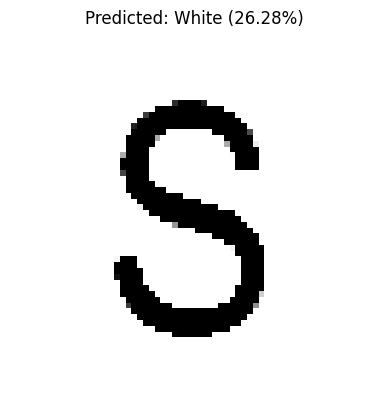

Class Confidence Percentages:
H: 24.87%
S: 24.14%
U: 24.72%
White: 26.28%

Final Prediction: White with 26.28% confidence.


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Step 1: Load the Trained PyTorch Model
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the CNN Model Architecture (must match the trained model)
# Adjusted Model Definition
class LetterClassificationModel(nn.Module):
    def __init__(self):
        super(LetterClassificationModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=1),  # conv_layers.0
            nn.ReLU(),
            nn.BatchNorm2d(32),  # conv_layers.2
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),  # conv_layers.4
            nn.ReLU(),
            nn.BatchNorm2d(64),  # conv_layers.6
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),  # fc_layers.0
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 4)  # fc_layers.2
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Instantiate the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LetterClassificationModel().to(device)

# Load State Dict
model_path = "letter_classification_with_white.pth"
state_dict = torch.load(model_path, map_location=device)

# Fix Strict Loading by Ignoring Missing Keys (if necessary)
model.load_state_dict(state_dict, strict=False)
model.eval()

print("Model loaded successfully!")

# ------------------------------
# Step 2: Preprocess the Image
# ------------------------------
def preprocess_image(image_path):
    """
    Load an image, preprocess it to grayscale, resize it, and normalize for PyTorch.
    """
    # Load the image with OpenCV as grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Error: Image not found at {image_path}")

    # Resize the image to 64x64
    img_resized = cv2.resize(img, (64, 64))

    # Normalize and convert to tensor
    transform = transforms.Compose([
        transforms.ToTensor(),  # Converts to range [0,1]
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
    ])
    img_tensor = transform(img_resized).unsqueeze(0)  # Add batch dimension

    return img_tensor.to(device), img_resized

# ------------------------------
# Step 3: Make Prediction
# ------------------------------
def predict_image(image_path, model, class_labels):
    """
    Predict the class of an input image and display it with the result.
    Print confidence percentages for all classes.
    """
    # Preprocess the image
    img_tensor, img_display = preprocess_image(image_path)

    # Perform inference
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.softmax(outputs[0], dim=0).cpu().numpy()

    # Get predicted class
    predicted_class_index = np.argmax(probabilities)
    predicted_class = class_labels[predicted_class_index]
    confidence = probabilities[predicted_class_index] * 100

    # Display the image
    plt.imshow(img_display, cmap="gray")
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()

    # Print confidence percentages for all classes
    print("Class Confidence Percentages:")
    for i, class_label in enumerate(class_labels):
        print(f"{class_label}: {probabilities[i] * 100:.2f}%")

    print(f"\nFinal Prediction: {predicted_class} with {confidence:.2f}% confidence.")

# ------------------------------
# Step 4: Test the Model with a Photo
# ------------------------------
# Define class labels (must match the order of training)
class_labels = ["H", "S", "U", "White"]  # Include "White" as the fourth class

# Test Image Path
test_image_path = "S.png"  # Replace with your actual image path

# Predict and Display
predict_image(test_image_path, model, class_labels)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get ground truth and predictions
y_true = []
y_pred = []

# Reset validation generator to start from the beginning
val_generator.reset()

# Iterate through the validation data to gather true labels and predictions
for i in range(len(val_generator)):
    X_val, y_val = val_generator[i]  # Get the batch
    y_true.extend(np.argmax(y_val, axis=1))  # True labels
    predictions = model.predict(X_val)  # Predictions
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted labels

# Class labels
class_labels = list(val_generator.class_indices.keys())

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="Blues", values_format="d")

plt.title("Confusion Matrix")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'augmented_images_2000/H/H_17.jpg'

In [20]:
# prompt: remove all elemets form the folder augmented_images

import shutil
import os

# Specify the folder path
folder_path = "augmented_dataset"

# Check if the folder exists
if os.path.exists(folder_path):
  # Iterate through all files and subdirectories in the folder
  for filename in os.listdir(folder_path):
      file_path = os.path.join(folder_path, filename)
      try:
          if os.path.isfile(file_path):
              os.remove(file_path)  # Delete the file
          elif os.path.isdir(file_path):
              shutil.rmtree(file_path)  # Delete the subdirectory
      except Exception as e:
          print(f"Error deleting {file_path}: {e}")
  print(f"All files and subdirectories in '{folder_path}' have been removed.")

else:
  print(f"Folder '{folder_path}' does not exist.")

All files and subdirectories in 'augmented_dataset' have been removed.


Processing letter: H
Processing letter: S
Processing letter: U
Processing letter: white
Dataset augmentation completed successfully!
Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 659ms/step - accuracy: 0.5864 - loss: 0.9837 - val_accuracy: 1.0000 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 736ms/step - accuracy: 1.0000 - loss: 0.0153 - val_accuracy: 1.0000 - val_loss: 1.7507e-04 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 670ms/step - accuracy: 0.9985 - loss: 0.0096 - val_accuracy: 1.0000 - val_loss: 5.7211e-04 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 733ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 1.0000 - val_loss: 1.5901e-05 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 734ms/step - accuracy: 0.9984 - loss: 0.0043 - val_accuracy: 1.0000 - val_loss: 1.5302e-05 - learning_rate: 0.0010
Epo

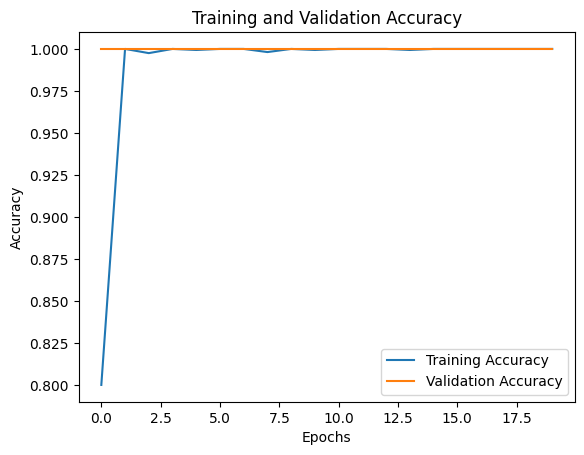

Model training completed and saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


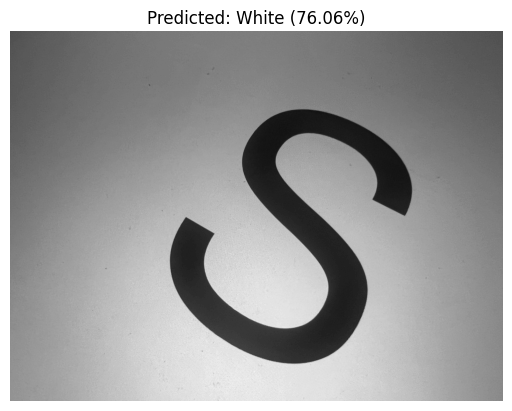

In [21]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# ------------------------------
# Step 1: Data Augmentation
# ------------------------------

# Function to add random brightness and texture
def augment_image(image, is_white=False):
    """
    Apply geometric transformations, brightness adjustments, and noise to an image.
    """
    if is_white:
        # For white class, optionally add slight noise and brightness adjustments
        noise = np.random.normal(0, 5, image.shape).astype(np.uint8)
        brightened = np.clip(image + noise, 0, 255).astype(np.uint8)
        return brightened

    # Random rotation (-45 to 45 degrees)
    angle = random.uniform(-45, 45)
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)

    # Random brightness adjustment
    brightness = random.uniform(0.5, 1.5)
    brightened = np.clip(rotated * brightness, 0, 255).astype(np.uint8)

    # Add Gaussian noise
    noise = np.random.normal(0, 15, brightened.shape).astype(np.uint8)
    noisy_image = cv2.add(brightened, noise)

    return noisy_image

# Create augmented dataset
def create_augmented_dataset(input_dir, output_dir, total_images_per_class=500):
    """
    Generate augmented images from input letter images.
    """
    os.makedirs(output_dir, exist_ok=True)

    for letter_file in os.listdir(input_dir):
        if letter_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            letter_name = os.path.splitext(letter_file)[0]
            is_white = "white" in letter_name.lower()
            print(f"Processing letter: {letter_name}")

            # Load the original image
            image_path = os.path.join(input_dir, letter_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                print(f"Error loading {image_path}")
                continue

            # Create letter folder
            letter_dir = os.path.join(output_dir, letter_name)
            os.makedirs(letter_dir, exist_ok=True)

            # Generate augmented images
            for i in range(total_images_per_class):
                augmented_image = augment_image(image, is_white=is_white)
                output_path = os.path.join(letter_dir, f"{letter_name}_{i}.png")
                cv2.imwrite(output_path, augmented_image)

    print("Dataset augmentation completed successfully!")

# ------------------------------
# Step 2: Model Training
# ------------------------------

# Paths
input_dir = "original_letters"  # Folder containing original H, S, U, white.png images
output_dir = "augmented_dataset"  # Folder for augmented images
train_dir = output_dir

# Generate Augmented Dataset
create_augmented_dataset(input_dir, output_dir, total_images_per_class=500)

# Data Preprocessing
img_size = (64, 64)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

# CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes: H, S, U, White
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

# ------------------------------
# Step 3: Plot Training Curves
# ------------------------------

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Save the model
model.save("letter_classification_with_white.h5")
print("Model training completed and saved!")

# ------------------------------
# Step 4: Testing the Model
# ------------------------------

def test_model(image_path, model):
    """
    Test a single image using the trained model.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (64, 64))
    img_normalized = img_resized / 255.0
    img_input = img_normalized.reshape(1, 64, 64, 1)

    predictions = model.predict(img_input)
    class_names = ['H', 'S', 'U', 'White']
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions) * 100

    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

# Test the model with a sample image
test_image_path = "S_test.JPG"  # Replace with path to test white image
test_model(test_image_path, model)

Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


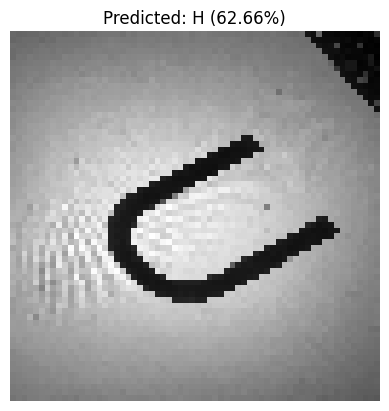

Class Confidence Percentages:
H: 62.66%
S: 0.00%
U: 37.17%
White: 0.17%

Final Prediction: H with 62.66% confidence.


In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# ------------------------------
# Step 1: Load the Trained Model
# ------------------------------
# Load the updated saved model
model = load_model("letter_classification_with_white.h5")
print("Model loaded successfully!")

# ------------------------------
# Step 2: Preprocess the Image
# ------------------------------
def preprocess_image(image_path):
    """
    Load an image, preprocess it to grayscale, resize it, and normalize.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load the image in grayscale
    if img is None:
        raise ValueError(f"Error: Image not found at {image_path}")

    img_resized = cv2.resize(img, (64, 64))  # Resize to 64x64
    img_normalized = img_resized / 255.0     # Normalize pixel values to [0, 1]
    img_final = img_normalized.reshape(1, 64, 64, 1)  # Add batch and channel dimensions
    return img_final, img_resized

# ------------------------------
# Step 3: Make Predictions
# ------------------------------
def predict_image(image_path, model, class_labels):
    """
    Predict the class of an input image and display it with the result.
    """
    # Preprocess the image
    img_final, img_display = preprocess_image(image_path)

    # Predict the class
    predictions = model.predict(img_final)[0]  # Get predictions array
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_labels[predicted_class_index]
    confidence = predictions[predicted_class_index] * 100

    # Display the image and results
    plt.imshow(img_display, cmap="gray")
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()

    # Print the confidence for all classes
    print("Class Confidence Percentages:")
    for i, label in enumerate(class_labels):
        print(f"{label}: {predictions[i] * 100:.2f}%")
    print(f"\nFinal Prediction: {predicted_class} with {confidence:.2f}% confidence.")

# ------------------------------
# Step 4: Test the Model
# ------------------------------
# Define class labels (including the new "White" class)
class_labels = ["H", "S", "U", "White"]  # Updated with the "White" class

# Provide the test image path
test_image_path = "U_test.JPG"  # Replace with your test image file path

# Make prediction
predict_image(test_image_path, model, class_labels)


EXTRA

In [ ]:
import tensorflow as tf
import numpy 
import cv2
import matplotlib.pyplot as plt
import tensorflow_datasets as tfd
"""""codigo comentado si se quiere usar imagenes de emnist para pruebas
#funcion de normalizacion
def normalizar(images,labels):
    images=tf.cast(images,tf.float32)#convierte los valores de las imagenes a float32
    images/=255
    return images, labels
#descarga de imagenes
data,metadata=tfd.load("mnist",as_supervised=True,with_info=True)
#obetener imagenes de entrenamietno y prueba
data_train,data_test=data["train"],data["test"]
#normalizar
data_train=data_train.map(normalizar)#aplica los valores de data a la funcion normalizar
data_test=data_test.map(normalizar)
#agregar a cache
data_train=data_train.cache()
data_test=data_test.cache()
"""
#carga de modelo e imagen de prueba
model=tf.keras.models.load_model("/Users/luisbenvenuto/Desktop/PVision/Vision/redConvolucionalHSU.h5")
image=cv2.imread("/Users/luisbenvenuto/Desktop/PVision/Vision/original_images/H.png",cv2.IMREAD_GRAYSCALE)
if image is None:
    print("error al cargar la imagen")
image=cv2.resize(image,(28,28))
#condicional para distinguir entre imagen en blanco o imagen con letra
if numpy.all(image>100) :
    print("blanco")
else:
    print("letra")
    letter_detected=["H","S","U"]
    #normalizar imagen 
    image=image/255.0
    image = numpy.expand_dims(image, axis=-1)  # Agregar un canal (grayscale)
    image = numpy.expand_dims(image, axis=0)  # Agregar dimensión de batch
    #mostrar imagen normalizada
    cv2.imshow("Imagen", image.squeeze())  # Eliminar dimensiones extra para mostrar la imagen
    # Espera a presionar una tecla para cerrar la imagen
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    #procesar resultado e imprimirlo
    resultado=model.predict(image)
    resultado=numpy.argmax(resultado)
    resultado=letter_detected[resultado]
    print(resultado)